### VAESIM v6

1) Build on best performances from sweep
2) Introduce temperature scaling


In [1]:
%pip install imutils
%pip install opencv-python
%pip install torchextractor
%pip install omegaconf


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import sys
sys.path.append("vaesim")
import torch
import torch.distributions as D
import matplotlib.pyplot as plt

import numpy as np
from torch import nn

from classes.Architectures import VAEDecoder, VAEEncoder, Discriminator,cVAEDecoder
from classes.Cluster import VAESIM
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST,CIFAR10
from torchvision.transforms import Compose,ToTensor,Resize,PILToTensor

from torchsummary import summary

from torch import distributions as D
from torch.nn.functional import softmax
import wandb

from imutils import paths
import matplotlib.pyplot as plt
import tqdm
from utils.callbacks import *

from sklearn.metrics import classification_report
from scipy.optimize import linear_sum_assignment
from utils.utils import linear_assignment
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.manifold import TSNE

import os
import seaborn as sns
#from coclust.evaluation.external import accuracy
import pandas as pd
wandb.login()
from evaluations import *

In [3]:
class encoder(nn.Module):
    
    def __init__(self,latent_dim=50,n_conv=3,n_init_filters=32,input_channels=1):
        super().__init__()
        layers=[]
        for i in range(n_conv):
            if i==0:
                layers.append(nn.Conv2d(input_channels,n_init_filters,kernel_size=4,stride=2,padding=1))
                layers.append(nn.ReLU())
                layers.append(nn.BatchNorm2d(n_init_filters))
            else:
                layers.append(nn.Conv2d(n_init_filters*(2**(i-1)),n_init_filters*2**i,kernel_size=4,stride=2,padding=1))
                layers.append(nn.ReLU())
                layers.append(nn.BatchNorm2d(n_init_filters*2**i))
        layers.append(nn.Flatten())
        layers.append(nn.LazyLinear(latent_dim))
        
        self.network=nn.Sequential(*layers)
        
    def forward(self,x):
        return self.network(x)
        
        
        

In [4]:
class decoder(nn.Module):

    def __init__(self, latent_dim=50,target_shape=(1,28,28) , n_conv=2, n_init_filters=64, condition_dim=10):

        super().__init__()

        self.condition_dim=condition_dim



        # infer the starting dimension.
        target_shape_side = target_shape[-1]



        self.startDim = target_shape_side // (2 ** n_conv)

        self.n_init_filters=n_init_filters
        
        #self.predecoder=nn.Unflatten(self.first_channels*self.startDim*self.startDim)
        self.predecoder=nn.Linear(latent_dim,self.n_init_filters*self.startDim*self.startDim)
        self.unflatten=nn.Unflatten(1,(self.n_init_filters,self.startDim,self.startDim))

        self.condition =  nn.Linear(self.condition_dim,self.startDim*self.startDim)
        self.condition2shape = nn.Unflatten(1, (1,self.startDim , self.startDim))
        feature_layers = []
        for i in range(n_conv):
            if i==0:
                feature_layers.append(nn.LazyConvTranspose2d(n_init_filters,kernel_size=4,stride=2,padding=1))
            else:
                feature_layers.append(nn.ConvTranspose2d(n_init_filters*(2**(i-1)),n_init_filters*2**i,kernel_size=4,stride=2,padding=1))

        self.features = nn.Sequential(*feature_layers)

        self.decoder_output=nn.LazyConvTranspose2d(target_shape[0],3,padding=1)
        self.activation=nn.Sigmoid()

    def forward(self,x,c):
        x = self.predecoder(x)
        x= self.unflatten(x)

        c= self.condition(c)
        c= self.condition2shape(c)
        
        x= torch.concat((x,c),axis=1)
        x = x.view(x.shape[0], -1, self.startDim, self.startDim)
        x = self.features(x)
        x = self.decoder_output(x)
        x = self.activation(x)

        return x

#### TRAINING

In [5]:
n_basis=40
latent_dim=32
input_dim=(1,32,32)

sample_cluster=False
kl_weight=5e-3
sim_weight=0.1
similarity=True
kl=True
reinit=0.

temperature=5

## using VAEEncoder
encoder_architecture=[[0,64],[0,128],[0,256]]

e=VAEEncoder( latent_dim=latent_dim,  conv_layer_list=encoder_architecture)
d=decoder(latent_dim=latent_dim,condition_dim=n_basis,n_init_filters=128,target_shape=input_dim)


model=VAESIM(input_dim=input_dim,latent_dim=latent_dim,encoder=e,decoder=d,n_basis=n_basis,weight=kl_weight,sim_weight=sim_weight,similarity=similarity,kl=kl,sample_cluster=sample_cluster,reinit=reinit,temperature=temperature,schedule=True,ema=0.95)


EPOCHS=20
BS=2000
INIT_LR=1e-4

config={"dataset":"MNIST10", "type":"VAESIM","latent_dim":latent_dim, "n_basis":n_basis, "input_dim":input_dim}
config["epochs"]=EPOCHS
config["BS"]=BS
config["init_lr"]=INIT_LR

config["sample_cluster"]=sample_cluster
config["use_kl_loss"]=kl
config["use_similarity_loss"]=similarity
config["reinitialization_probability"]=reinit
config["kl_weight"]=kl_weight
config["sim_weight"]=sim_weight




wandb.init(project="NeuroGEN_Pytorch",config=config)



[INFO] Running model with KL: True, similarity loss: True and sampling: False temperature: 5 reinitilize: 0.0 ema: 0.95 


/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
# Get cpu or gpu device for training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Using {device} device")

Using cuda:0 device


## Run this cell to Init the basis

Computing t-SNE to visualize from 32 to 2 dim - this could take a while..


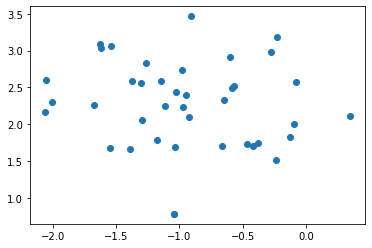

In [7]:
x=torch.rand(BS,*input_dim).to(device)
z_mean,z_log_var=model.encoder(x)
q_z = D.normal.Normal(z_mean, torch.exp(0.5 * z_log_var))
z=q_z.rsample()

model.init_basis(z.detach().cpu())

In [8]:
summary(model,input_dim)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,088
      ConvResBlock-2           [-1, 64, 16, 16]               0
            Conv2d-3            [-1, 128, 8, 8]         131,200
      ConvResBlock-4            [-1, 128, 8, 8]               0
            Conv2d-5            [-1, 256, 4, 4]         524,544
      ConvResBlock-6            [-1, 256, 4, 4]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                   [-1, 32]         131,104
            Linear-9                   [-1, 32]         131,104
       VAEEncoder-10       [[-1, 32], [-1, 32]]               0
           Linear-11                 [-1, 8192]         270,336
        Unflatten-12            [-1, 128, 8, 8]               0
           Linear-13                   [-1, 64]           2,624
        Unflatten-14              [-1, 

In [9]:
transform=Compose([Resize(32),ToTensor()])

train_dataset=MNIST('mnist_train', train=True, download=True,
                             transform=transform)
test_dataset=MNIST('mnist_test', train=False, download=True,
                             transform=transform)

train_dataloader=DataLoader(train_dataset,batch_size=BS,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=BS,shuffle=False)

In [10]:
base_path="models/vaesim_mnist"
os.makedirs(base_path,exist_ok=True)

In [11]:
train=True
if train:
    optimizer=torch.optim.Adam(model.parameters(),lr=INIT_LR)
    #optimizer=torch.optim.SGD(model.parameters(),lr=INIT_LR,momentum=0.9)
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.2)

    loss_history,recon_loss_history,kl_loss_history,sim_loss_history=model.fit(train_dataloader=train_dataloader,val_dataloader=test_dataloader,epochs=EPOCHS,optimizer=optimizer,device=device,wandb_log=False,save_model=base_path,early_stop=10,scheduler=scheduler)

else:
    model.load_state_dict(torch.load("models/vaesim_mnist/model.pt"))
    model.basis=torch.load("models/vaesim_mnist/vaesim_basis.pt")
    model=model.to(device)
    model.device=device

Epoch 0: 100%|█| 30/30 [00:12<00:00,  2.36batch/s, loss=0.409, sim_loss=0.347, recon_loss=0.06, kl_loss
/home/matteo/Unsupervised/vaesim_baselines/VAESIM/../../NeuroGEN_Pytorch/utils/callbacks.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c=torch.nn.functional.softmax(logprobs/0.25)
Epoch 1: 100%|█| 30/30 [00:12<00:00,  2.39batch/s, loss=0.241, sim_loss=0.199, recon_loss=0.0371, kl_lo
Epoch 2: 100%|█| 30/30 [00:11<00:00,  2.52batch/s, loss=0.188, sim_loss=0.156, recon_loss=0.0264, kl_lo
Epoch 3: 100%|█| 30/30 [00:11<00:00,  2.55batch/s, loss=0.186, sim_loss=0.159, recon_loss=0.0208, kl_lo
Epoch 4: 100%|█| 30/30 [00:12<00:00,  2.40batch/s, loss=0.16, sim_loss=0.136, recon_loss=0.0173, kl_los
Epoch 5: 100%|█| 30/30 [00:12<00:00,  2.44batch/s, loss=0.145, sim_loss=0.123, recon_loss=0.0152, kl_lo
Epoch 6: 100%|█| 30/30 [00:12<00:00,  2.40batch/s, loss=0.125, sim_loss=0.104, recon_loss=0.0138, kl_lo
Epoch 7

### Baseline Evaluation

In [12]:
cl_train=[]
y_train=[]
z_train=[]


cl_test=[]
y_test=[]
z_test=[]

with torch.no_grad():
    for x,y in tqdm.tqdm(train_dataloader):
        x=x.to(device)
        z_mu,z_sigma=model.encoder(x)
        dist=D.normal.Normal(z_mu, torch.exp(0.5 * z_sigma))
        z=dist.sample()
        sim=model.compute_similarity(z)
        soft_sim=softmax(sim,dim=1)
        cl_train.append(soft_sim.argmax(dim=1).cpu().numpy())
        z_train.append(z.cpu().numpy())
        y_train.append(y.cpu().numpy())
        
    for x,y in tqdm.tqdm(test_dataloader):
        x=x.to(device)
        z_mu,z_sigma=model.encoder(x)
        dist=D.normal.Normal(z_mu, torch.exp(0.5 * z_sigma))
        z=dist.sample().cpu()
        sim=model.compute_similarity(z)
        soft_sim=softmax(sim,dim=1)
        cl_test.append(soft_sim.argmax(dim=1).cpu().numpy())
        
        z_test.append(z.cpu().numpy())
        y_test.append(y.cpu().numpy())
        
    cl_train=np.concatenate(cl_train,0)
    z_train=np.concatenate(z_train,0)
    y_train=np.concatenate(y_train,0)

    cl_test=np.concatenate(cl_test,0)
    z_test=np.concatenate(z_test,0)
    y_test=np.concatenate(y_test,0)

100%|████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


In [13]:
config={"name":"VAESIM","dataset":"MNIST","n_cluster":40}
wandb.init(project="VAESIM_CHARACT",config=config)

In [14]:
outputs=model_evaluation(z_train,y_train,z_test,y_test,cl_train,cl_test,device="cuda",n_cluster=40)
wandb.log(outputs)

[INFO] compute mappings and stat accuracy
{0: 4, 1: 9, 2: 4, 3: 0, 4: 9, 5: 1, 6: 6, 7: 4, 8: 5, 9: 6, 10: 3, 11: 4, 12: 9, 13: 7, 14: 7, 15: 8, 16: 8, 17: 1, 18: 8, 19: 7, 20: 3, 21: 2, 22: 1, 23: 2, 24: 6, 25: 5, 26: 2, 27: 7, 28: 9, 29: 2, 30: 8, 31: 0, 32: 3, 33: 3, 34: 6, 35: 5, 36: 0, 37: 1, 38: 5, 39: 4}
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       980
           1       0.85      0.99      0.91      1135
           2       0.92      0.83      0.88      1032
           3       0.77      0.84      0.80      1010
           4       0.80      0.74      0.77       982
           5       0.85      0.65      0.74       892
           6       0.88      0.95      0.92       958
           7       0.85      0.85      0.85      1028
           8       0.77      0.79      0.78       974
           9       0.73      0.71      0.72      1009

    accuracy                           0.83     10000
   macro avg       0.83      0.83    

/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.96      0.96       892
           6       0.97      0.98      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.95      0.96      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

[INFO] compute linear accuracy


[LINEAR] epoch 9 loss: 0.590460479259491 acc: 0.8645833730697632: 100%|█| 10/10 [00:05<00:00,  1.72it/s


              precision    recall  f1-score   support

           0       0.91      0.94      0.93       980
           1       0.89      0.96      0.92      1135
           2       0.87      0.81      0.84      1032
           3       0.85      0.84      0.84      1010
           4       0.86      0.85      0.86       982
           5       0.80      0.78      0.79       892
           6       0.88      0.91      0.90       958
           7       0.88      0.85      0.87      1028
           8       0.82      0.81      0.82       974
           9       0.82      0.84      0.83      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [15]:
# batch=next(iter(test_dataloader))

# model.evaluate(batch,train_dataloader,test_dataloader,wandb_log=True,n_semi=6,lin_epochs=200)


## FINE

In [16]:
# plt.plot(loss_history,label="loss")
# plt.plot(recon_loss_history,label="recon_loss")
# plt.plot(kl_loss_history,label="kl_loss")
# plt.plot(sim_loss_history,label="sim_loss")

# plt.legend()

In [17]:

# for x,y in test_dataloader:
#     x2,z,s=model(x.to(device))
#     break

In [18]:
# model.basis.shape

In [19]:
# fig,axs=plt.subplots(2,20,figsize=(15,2))

# for i in range(20):
#     axs[0,i].imshow(x[i].permute(1,2,0))
#     axs[1,i].imshow(x2[i].detach().permute(1,2,0).cpu())